# 全卷积网络
FCN采用卷积神经网络实现了从图像像素到像素类别的变换。

通过ConvTranspose2d，我们可以将中间下采样的特特征图还原成输入图像的尺寸，因此输入累呗预测与输入图像在像素级别具有一一对应的关系

In [1]:
# 首先import一大堆东西
%matplotlib inline
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append("../")
from pltutils import *
import torchvision as tv

In [2]:
# 构造模型
pretraind_net = tv.models.resnet18(pretrained=True)
list(pretraind_net.children())[-3:]
      

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

# 创建一个全卷积网络，
复制了ResNet-18中的大部分预训练层，除了最后的GMP和LINEAR层。

In [3]:
net= nn.Sequential(*list(pretraind_net.children())[:-2])

In [4]:
X = t.rand(size=(1,3,320,480))
net.forward(X).shape

torch.Size([1, 512, 10, 15])

可以看到我们的高宽减少到原来的1/32，即10和15，而通道数增加了很多。

接下来我们使用1\*1的卷积层将输出通道数转换为Pascal VOC2012数据集的类数(21类)。最后需要将特征图的宽度和高度增加32倍，从而还原高和宽。

In [5]:
num_classes = 21
net.add_module("final_conv",nn.Conv2d(512,num_classes,kernel_size=1))
net.add_module("transpose_conv",nn.ConvTranspose2d(num_classes,num_classes,kernel_size=64,padding=16,stride=32))

$$H_{out} = (H_{in} - 1) \times \text{stride}[0] - 2 \times \text{padding}[0] + \text{dilation}[0]\\
                        \times (\text{kernel\_size}[0] - 1) + \text{output\_padding}[0] + 1\\
                        
    W_{out} = (W_{in} - 1) \times \text{stride}[1] - 2 \times \text{padding}[1] + \text{dilation}[1]\\
                        \times (\text{kernel\_size}[1] - 1) + \text{output\_padding}[1] + 1                    
$$

算下来是

$$
H_{out} = (H_{in}-1) \times 32 - 2 \times 16 + (64) = 32 \times H_{in}
$$

对于W也有一样的

$$
W_{out} = (W_{in}-1) \times 32 - 2 \times 16 + (64) = 32 \times W_{in}
$$

# 初始化转置卷积层
在图像处理中，我们有时候需要将图像放大，即上采样(upsampling),双线性插值是常用的上采样方法之一，它也经常用于初始化转置卷积层

双线性插值的上采样可以通过转置卷积层实，内核由bilinear_kernel函数构造。

In [6]:
def bilinear_kernel(in_channels,out_channels,kernel_size):
    factor = (kernel_size +1)//2
    
    if kernel_size %2 ==1:
        center = factor -1

    else:
        center = factor -0.5
    
    og = (t.arange(kernel_size).reshape(-1,1),
        t.arange(kernel_size).reshape(1,-1))
    
    filt = (1 -t.abs(og[0] - center)/factor)*(1-t.abs(og[1]-center)/factor)

    weight = t.zeros((in_channels,out_channels,kernel_size,kernel_size))
    weight [range(in_channels), range(out_channels),:,:] = filt
    return weight

In [7]:
conv_trans = nn.ConvTranspose2d(3,3,kernel_size=4,padding=1 ,stride=2,bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3,3,4))

tensor([[[[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0

In [8]:
import PIL.Image as Image
img = tv.transforms.ToTensor()(Image.open("../figures/cat.jpg"))
X = img.unsqueeze(0)
Y = conv_trans.forward(X)
out_img = Y[0].permute(1,2,0).detach()

input image shape: torch.Size([663, 575, 3])
output image shape: torch.Size([1326, 1150, 3])


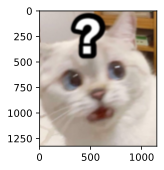

In [9]:
# 双线性插值法放大图片，在这里将图片放大了4倍
set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
plt.imshow(img.permute(1, 2, 0))
print('output image shape:', out_img.shape)
plt.imshow(out_img)

In [10]:
W = bilinear_kernel(num_classes,num_classes,64)
net.transpose_conv.weight.data.copy_(W)

tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

# 读取数据集

使用SemanticSegmentationAndDataset.ipynb中的数据集

In [11]:
batch_size , crop_size = 32,(320,480)
train_iter , test_iter = load_data_voc(None,batch_size,crop_size,0)

read 1114 examples
read 1078 examples


# 训练模型
还是使用softmax回归，使用交叉熵损失

loss 0.397, train acc 0.876, test acc 0.849
79.8 examples/sec on [device(type='cuda', index=0)]


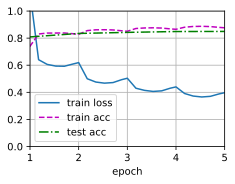

In [12]:
def loss(inputs,targets):
    return F.cross_entropy(inputs,targets,reduction="none").mean(1).mean(1)

num_epochs,lr,wd = 5,0.001,1e-3
trainer = t.optim.SGD(net.parameters(),lr=lr,weight_decay=wd)
train_ch13(net,train_iter,test_iter,loss,trainer,num_epochs)

# 预测


In [13]:
def predict(img):
    X =test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net.forward(X.to("cuda:0")).argmax(dim=1)
    return pred.reshape(pred.shape[1],pred.shape[2])

def label2image(pred:t.Tensor):
    colormap = t.tensor(VOC_COLORMAP,device="cuda:0")
    X= pred.long()
    return colormap[X,:]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

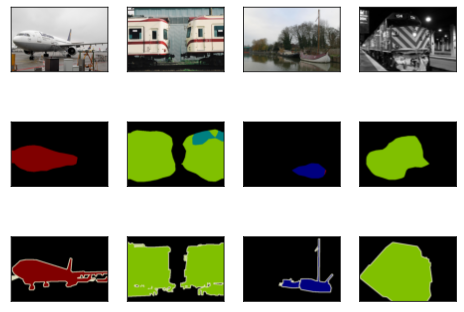

In [15]:
voc_dir = "../dataset/VOCdevkit/VOC2012"
test_images, test_labels = read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = tv.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1, 2, 0), pred.cpu(),
             tv.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1, 2, 0)]
show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2)
